In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
tf.random.set_seed(123)

import tensorflow_probability as tfp
tfd = tfp.distributions

`Independent` allows to turn batches of univariate distributions a multivariate distributions

In [2]:
# Start by defining a batch of two univariate Gaussians, then
# combine them into a bivariate Gaussian with independent components

locs = [-1, 1]
scales = [0.5, 1.]
batch_of_normals = tfd.Normal(loc = locs, scale = scales)

2022-02-25 23:02:44.306171: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


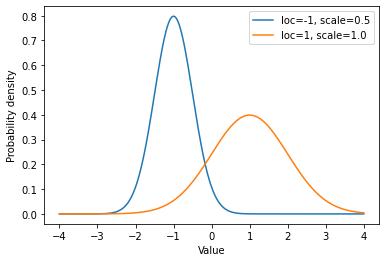

In [3]:
# Univariate density functions

import seaborn as sns

t = np.linspace(-4, 4, 10000)
densities = batch_of_normals.prob(np.repeat(t[:, np.newaxis], 2, axis=1)) # each column is a vector of densities for one distn

sns.lineplot(x = t, y = densities[:, 0], label='loc={}, scale={}'.format(locs[0], scales[0]))
sns.lineplot(x = t, y = densities[:, 1], label='loc={}, scale={}'.format(locs[1], scales[1]))
plt.ylabel('Probability density')
plt.xlabel('Value')
plt.legend()
plt.show()

In [4]:
# Check their batch_shape and event_shape

batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [5]:
# Use Independent to convert the batch shape to the event shape

bivariate_normal_from_Independent = tfd.Independent(batch_of_normals, 
                                                    reinterpreted_batch_ndims = 1)

In [6]:
# Note that dimension from batch_shape has shifted to event_shape

bivariate_normal_from_Independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

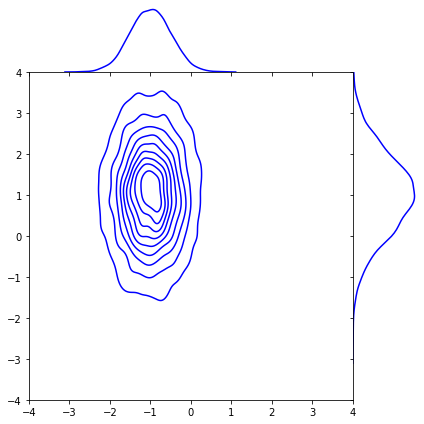

In [7]:
# Create a plot showing joint density contours and marginal density functions

samples = bivariate_normal_from_Independent.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x = x1, y = x2, kind="kde", space=0, color='b', xlim=[-4, 4], ylim=[-4, 4])

In [8]:
# Use MultivariateNormalDiag to create the equivalent distribution
# Note that diagonal covariance matrix => no correlation => independence (for the multivariate normal distribution)

bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc = locs, scale_diag = scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

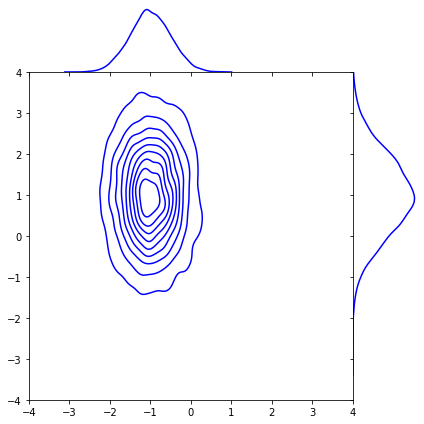

In [9]:
# Plot the joint density function of bivariate_normal_from_Independent
# Refer back to bivariate_normal_from_Independent to show that the plot is the same
# Summarise how Independent has been used

samples = bivariate_normal_from_Multivariate.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
sns.jointplot(x = x1, y = x2, kind="kde", space=0, color='b', xlim=[-4, 4], ylim=[-4, 4])

#### Shifting batch dimensions to event dimensions using 
`reinterpreted_batch_ndims`

In [10]:
# Demonstrate use of reinterpreted_batch_ndims
# By default all batch dims except the first are transferred to event dims

loc_grid = [[-100., -100.],
            [100., 100.],
            [0.,   0.]]
scale_grid = [[1., 10.],
              [1., 10.],
              [1., 1.]]

normals_batch_3by2_event_1 = tfd.Normal(loc=loc_grid, scale=scale_grid)

In [11]:
# Highlight batch_shape

normals_batch_3by2_event_1

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [12]:
# We now have a batch of 3 bivariate normal distributions,
# each parametrised by a column of our original parameter grid

normals_batch_3_event_2 = tfd.Independent(normals_batch_3by2_event_1, 1) #reinterpreted_batch_ndims = 1

normals_batch_3_event_2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float32>

In [13]:
# Evaluate log_prob

normals_batch_3_event_2.log_prob(value = [[-10., 10.],
                                          [100., 100.],
                                          [1., 1.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.1146406e+03, -4.1404624e+00, -2.8378770e+00], dtype=float32)>

In [14]:
# Can reinterpret _all_ batch dimensions as event dimensions

normals_batch_1_event_3by2 = tfd.Independent(normals_batch_3by2_event_1, 2)
normals_batch_1_event_3by2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [15]:
# Take log_probs 
normals_batch_1_event_3by2.log_prob(value = [[-10., 10.],
                                          [100., 100.],
                                          [1., 1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=-4121.619>

### Using `Independent` to build a Naive Bayes classifier

#### Introduction to `newsgroups` data set

In this tutorial, just load the dataset, fetch train/test splits, probably choose a subset of the data.

Construct the class conditional feature distribution (with Independent, using the Naive Bayes assumption) and sample from it.

We can just use the ML estimates for parameters, in later tutorials we will learn them.



In [16]:
# Convenience function for retrieving the 20 newsgroups data set

# Usenet was a forerunner to modern internet forums
# Users could post and read articles
# Newsgroup corresponded to a topic
# Example topics in this data set: IBM computer hardware, baseball
# Our objective is to use an article's contents to predict its newsgroup,
# a 20-class classification problem.

# 18000 newsgroups, posts on 20 topics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer


In [17]:
# Get the train data

newsgroups_data = fetch_20newsgroups(data_home = '20_Newsgroup_Data/', subset = 'train')


In [18]:
# More information about the data set
print(newsgroups_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [19]:
# Example article

print(newsgroups_data['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [20]:
# Associated label

newsgroups_data['target'][0]

7

In [21]:
# Name of label

newsgroups_data['target_names'][7]

'rec.autos'

In [22]:
# Preprocessing boilerplate

n_documents = len(newsgroups_data['data'])

count_vectorizer = CountVectorizer(input='content', binary=True,
                                   max_df=0.25, min_df=1.01/n_documents) # ignore common words, words that appear once

binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_data['data']) # input is a list of strings

In [23]:
# Check shape

binary_bag_of_words.shape

(11314, 56365)

In [24]:
# Check that the fit has been successful

count_vectorizer.inverse_transform(binary_bag_of_words[0, :])

[array(['lerxst', 'wam', 'umd', 'where', 'thing', 'car', 'rac3',
        'maryland', 'college', 'park', '15', 'wondering', 'anyone',
        'could', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked',
        'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors',
        'were', 'really', 'small', 'addition', 'front', 'bumper',
        'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine',
        'specs', 'years', 'production', 'made', 'history', 'whatever',
        'info', 'funky', 'looking', 'please', 'mail', 'thanks', 'il',
        'brought', 'neighborhood'], dtype='<U80')]

In [25]:
# Dict that will be useful later 

inv_vocabulary = {value:key for key, value in count_vectorizer.vocabulary_.items()}

#### A Naive Bayes classifier for `newsgroup`

Each feature vector $x$ is a list of indicators for whether a word appears in the article. $x_i$ is 1 if the $i$th word appears, and 0 otherwise. `inv_vocabulary` matches word indices $i$ to words.

Each label $y$ is a value in $0, 1, \ldots, 19$.

The parts of a naive Bayes classifier for this problem can be summarised as:  


- A probability distribution for the feature vector by class, $p(x|y = j)$ for each $j = 0, 1, \ldots, 19$. These probability distributions are assumed to have independent components: we can factorize the joint probability as a product of marginal probabilities
\begin{equation}
    p(x|y = j) = \prod_{i=1}^d p(x_i|y = j)
\end{equation}
These marginal probability distributions are Bernoulli distributions, each of which has a single parameter $\theta_{ji} := p(x_i = 1|y = j)$. This parameter is the probability of observing word $i$ in an article of class $j$. 

- We will use the Laplace smoothed maximum likelihood estimate to compute these parameters. Laplace smoothing involves adding small counts to every feature for each class. Else, if a feature did not appear in the training set of a class, but then we observed it in our test data the log probability would be undefined.

- A collection of class prior probabilities $p(y = j)$. These will be set by computing the class base rates in the training set.  


- A function for computing the probability of class membership via Bayes' theorem:  

\begin{equation}
    p(y = j|x) = \frac{p(x|y = j)p(y = j)}{p(x)}
\end{equation}

In [26]:
# Compute the parameter estimates (adjusted fraction of documents in class that contain word)

n_classes = newsgroups_data['target'].max() + 1
y = newsgroups_data['target']
n_words = binary_bag_of_words.shape[1]

alpha = 1e-6 # parameters for Laplace smoothing

theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
for c_k in range(n_classes): # 0, 1, ..., 19
    class_mask = (y == c_k)
    N = class_mask.sum() # number of articles in class
    theta[c_k, :] = (binary_bag_of_words[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

In [27]:
# Check whether the most probable word in each class is reasonable

most_probable_word_ix = theta.argmax(axis=1) # most probable word for each class

for j, ix in enumerate(most_probable_word_ix):
    print('Most probable word in class {} is "{}".'.format(newsgroups_data['target_names'][j],
                                                           inv_vocabulary[ix]))

Most probable word in class alt.atheism is "people".
Most probable word in class comp.graphics is "graphics".
Most probable word in class comp.os.ms-windows.misc is "windows".
Most probable word in class comp.sys.ibm.pc.hardware is "thanks".
Most probable word in class comp.sys.mac.hardware is "mac".
Most probable word in class comp.windows.x is "window".
Most probable word in class misc.forsale is "sale".
Most probable word in class rec.autos is "car".
Most probable word in class rec.motorcycles is "dod".
Most probable word in class rec.sport.baseball is "he".
Most probable word in class rec.sport.hockey is "ca".
Most probable word in class sci.crypt is "clipper".
Most probable word in class sci.electronics is "use".
Most probable word in class sci.med is "reply".
Most probable word in class sci.space is "space".
Most probable word in class soc.religion.christian is "god".
Most probable word in class talk.politics.guns is "people".
Most probable word in class talk.politics.mideast is 

In [28]:
theta.shape

(20, 56365)

In [29]:
# Define a distribution for each class

batch_of_bernoullis = tfd.Bernoulli(probs = theta)

p_x_given_y = tfd.Independent(batch_of_bernoullis, 1)

p_x_given_y

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[20] event_shape=[56365] dtype=int32>

In [30]:
# Take a sample of words from each class

n_samples = 10
sample = p_x_given_y.sample(n_samples)

sample.shape

TensorShape([10, 20, 56365])

In [31]:
# Choose a class

chosen_class = 15
newsgroups_data['target_names'][chosen_class]

'soc.religion.christian'

In [32]:
# Indicators for words that appear in the sample

class_sample = sample[:, chosen_class, :]
class_sample

<tf.Tensor: shape=(10, 56365), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [33]:
# Perform inverse transform to test quality of fit

count_vectorizer.inverse_transform(class_sample)

[array(['03', '13', '22', '27', '30', '36', '44', '93', '_any_', 'above',
        'accomplished', 'advance', 'after', 'age', 'ancestors',
        'asserting', 'athena', 'athos', 'audience', 'avoid', 'back',
        'being', 'big', 'bnr', 'byler', 'call', 'certain', 'chord',
        'christ', 'christians', 'come', 'command', 'commanded',
        'concerned', 'conclusion', 'considered', 'convert', 'correlation',
        'covington', 'current', 'davidians', 'day', 'decipher', 'did',
        'difficult', 'driving', 'ecclesiastical', 'ecn', 'effectively',
        'encyclopedia', 'end', 'endowment', 'error', 'etc', 'existence',
        'explain', 'fallen', 'famine', 'far', 'feel', 'fortunately',
        'friendly', 'further', 'generally', 'gives', 'god', 'gods', 'good',
        'grasp', 'group', 'happened', 'help', 'him', 'hold', 'holy',
        'intended', 'interpreted', 'james', 'jew', 'john', 'joseph',
        'least', 'less', 'locals', 'lot', 'love', 'man', 'many', 'mean',
        'met',

***
<a id='sampling_and_log_probs'></a>
## Sampling and log probs

In [34]:
# Make Multivariate Distribution

normal_distributions = tfd.MultivariateNormalDiag(loc=[[0.5, 1], [0.1, 0], [0, 0.2]],
                                 scale_diag=[[2, 3], [1, 3], [4, 4]])
normal_distributions

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

In [35]:
# Sample
normal_distributions.sample(5)

<tf.Tensor: shape=(5, 3, 2), dtype=float32, numpy=
array([[[-0.77668655, -2.999619  ],
        [-1.0492779 , -2.4697692 ],
        [-3.462571  , -2.8477075 ]],

       [[ 1.351501  , -4.256754  ],
        [ 2.9928343 , -0.53360486],
        [-1.3705995 , -3.5753    ]],

       [[ 0.7231202 ,  4.1796002 ],
        [ 0.90749484,  2.3381221 ],
        [-1.2952777 ,  0.21723756]],

       [[ 1.377286  ,  2.3146658 ],
        [-0.5341492 ,  1.0650613 ],
        [-5.3061614 ,  5.405262  ]],

       [[ 0.77665675, -0.23458743],
        [ 0.8910945 ,  0.02855996],
        [ 6.540396  , -0.45694566]]], dtype=float32)>

In [36]:
# Multivariate Normal batched Distribution
# We are broadcasting batch shapes of `loc` and `scal_diag` 
# against each other

loc = [[[0.3, 1.5, 1.], [0.2, 0.4, 2.8]],
        [[2., 2.3, 8], [1.4, 1, 1.3]]]
scale_diag = [0.4, 1., 0.7]
normal_distributions = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
normal_distributions

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2, 2] event_shape=[3] dtype=float32>

In [37]:
# Use independent to move part of the batch shape

ind_normal_distributions = tfd.Independent(normal_distributions,
                                           reinterpreted_batch_ndims= 1)

ind_normal_distributions

<tfp.distributions.Independent 'IndependentMultivariateNormalDiag' batch_shape=[2] event_shape=[2, 3] dtype=float32>

In [38]:
# Draw some samples
samples = ind_normal_distributions.sample(5)
samples.shape


TensorShape([5, 2, 2, 3])

In [39]:
# `[B, E]` shaped input

inp = tf.random.uniform((2,2,3)) # same size as batch_shape + event_shape

ind_normal_distributions.log_prob(inp) # output is batch_shape

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-12.346934, -75.82132 ], dtype=float32)>

In [40]:
# `[E]` shaped input (broadcasting over batch size)

inp = tf.random.uniform((2,3)) # same size as event_shape

ind_normal_distributions.log_prob(inp) # output is batch_shape


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-12.441522, -73.21494 ], dtype=float32)>

In [41]:
#`[S, B, E]` shaped input (broadcasting over samples)

inp = tf.random.uniform((9,2,2,3)) #shape as Sample, Batch, Event

ind_normal_distributions.log_prob(inp) # output is sampls, batch_shape

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[-10.139837, -71.34117 ],
       [ -9.772417, -72.8571  ],
       [-12.456754, -68.5202  ],
       [ -9.006897, -71.11014 ],
       [ -9.342809, -81.18157 ],
       [ -9.947431, -68.748116],
       [ -7.176448, -66.988945],
       [-11.469181, -80.726776],
       [-10.869421, -64.40857 ]], dtype=float32)>

In [42]:
# `[S, b, e]` shaped input, where [b, e] is broadcastable over [B, E]

inp = tf.random.uniform((5, 1, 2, 1)) # shape is broadcastable

ind_normal_distributions.log_prob(inp) # output is sample, batch_shape


<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ -9.286251, -63.888245],
       [-10.366593, -83.21844 ],
       [-10.17972 , -78.43152 ],
       [ -9.265926, -67.43485 ],
       [ -9.444034, -73.98662 ]], dtype=float32)>

#### Naive Bayes example

Lets now use what we have learned and continue the Naive Bayes classifier we were building last tutorial.

In [43]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

In [44]:
# Making a function get_data which:
#   1) Fetches the 20 newsgroup dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):
    
    newsgroups_train_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                               subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                              subset='test', categories=categories)

    n_documents = len(newsgroups_train_data['data'])
    count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents)
    
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data'])
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data']) 

    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),  (test_binary_bag_of_words.todense(), newsgroups_test_data['target'])

In [45]:
# Defining a function to conduct Laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class.

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameters for Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

    return theta

In [46]:
# Getting a subset of the 20 newsgroup dataset

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories=categories)
smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

To now make our NB classifier we need to build three functions:
* Compute the class priors
* Build our class conditional distributions
* Put it all together and classify our data

In [47]:
# Function which computes the prior probability of every class based on frequency of occurence in 
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts / np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

In [48]:
# Run the function 
priors = class_priors(n_classes = len(categories), labels = train_labels)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [49]:
# Now we will do a function that given the feature occurence counts returns a Bernoulli distribution of 
# batch_shape=number of classes and event_shape=number of features.

def make_distributions(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs = probs)
    dist = tfd.Independent(batch_of_bernoullis,
                           reinterpreted_batch_ndims=1)
    return dist

tf_dist = make_distributions(smoothed_counts)
tf_dist

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[4] event_shape=[17495] dtype=int32>

In [104]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#   1) Computes the class conditional probabilities given the sample
#   2) Forms the joint likelihood
#   3) Normalises the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)   # likelihood....
    #joint_likelihood = tf.add(np.log(priors, dtype='float32'), cond_probs)
    joint_likelihood = np.log(priors, dtype='float') + cond_probs
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis = -1, keepdims = True)
    log_prob = joint_likelihood - norm_factor
    
    return log_prob

#### Computing log_probs

In [51]:
# Predicting one example from our test data

log_probs = predict_sample(tf_dist, test_data[0], priors)

log_probs

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-6.17363739e+01, -1.52587891e-05, -1.16197815e+01, -6.33276672e+01],
      dtype=float32)>

In [52]:
# Loop over our test data and classify.

probabilities = []
for sample, label in zip(test_data, test_labels):
    probabilities.append(tf.exp(predict_sample(tf_dist, sample, priors)))

probabilities = np.asarray(probabilities)
predicted_classes = np.argmax(probabilities, axis =-1)
print('f1 ', f1_score(test_labels, predicted_classes, average='macro'))

f1  0.7848499112849504


In [53]:
# Make a Bernoulli Naive Bayes classifier using sklearn with the same level of alpha smoothing. 

clf = BernoulliNB(alpha=1)
clf.fit(np.asarray(train_data), train_labels)
pred = clf.predict(np.asarray(test_data))
print('f1 from sklean ', f1_score(test_labels, pred, average='macro'))

f1 from sklean  0.7848499112849504


### Trainable distributions

In [128]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
import pandas as pd

In [107]:
# Define an exponential distribution
exponential = tfd.Exponential(rate = 0.3, name = 'exp')

<AxesSubplot:>

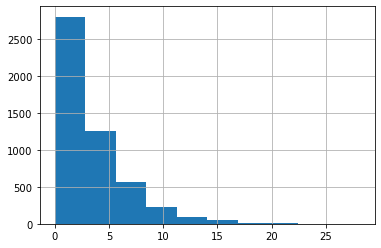

In [132]:
#exponential.sample(100)
a = exponential.sample(5000)
pd.Series(a).hist()

In [72]:
# Plot

plt.hist(exponential.sample(5000), bins=100, density=True)
plt.show()

In [131]:
#plt.hist(a, bins = 100, histtype='step')

In [109]:
# Define an exponential distribution with a trainable rate parameter

exp_train = tfd.Exponential(rate = tf.Variable(1., name = 'rate'), name = 'exp_train')

exp_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [76]:
# Define the negative log likelihood
def nll (x_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(x_train))

In [114]:
# Define a function to compute the loss and gradients
@tf.function
def get_loss_and_grads(x_train, distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(x_train, distribution)
    grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

In [116]:
# Optimize

def exponential_dist_optimisation(data, distribution):

    # Keep results for plotting
    train_loss_results = []
    train_rate_results = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    num_steps = 10

    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data, distribution)
        optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
        
        rate_value = distribution.rate.value()
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        
        print("Step {:03d}: Loss: {:.3f}: Rate: {:.3f}".format(i, loss, rate_value))
        
    return train_loss_results, train_rate_results

In [117]:
# Get some data and train

sampled_data = exponential.sample(5000)

train_loss_results, train_rate_results = exponential_dist_optimisation(data = sampled_data, distribution = exp_train)

Step 000: Loss: 3.371: Rate: 0.881
Step 001: Loss: 3.097: Rate: 0.770
Step 002: Loss: 2.856: Rate: 0.666
Step 003: Loss: 2.651: Rate: 0.573
Step 004: Loss: 2.488: Rate: 0.491
Step 005: Loss: 2.367: Rate: 0.425
Step 006: Loss: 2.288: Rate: 0.374
Step 007: Loss: 2.244: Rate: 0.339
Step 008: Loss: 2.224: Rate: 0.318
Step 009: Loss: 2.218: Rate: 0.307


In [121]:
# Predicted value for the rate parameter

pred_value = exp_train.rate.numpy()
exact_value = exponential.rate.numpy()

print("Exact rate: ", exact_value)
print("Pred rate:  ", pred_value)

Exact rate:  0.3
Pred rate:   0.30671155


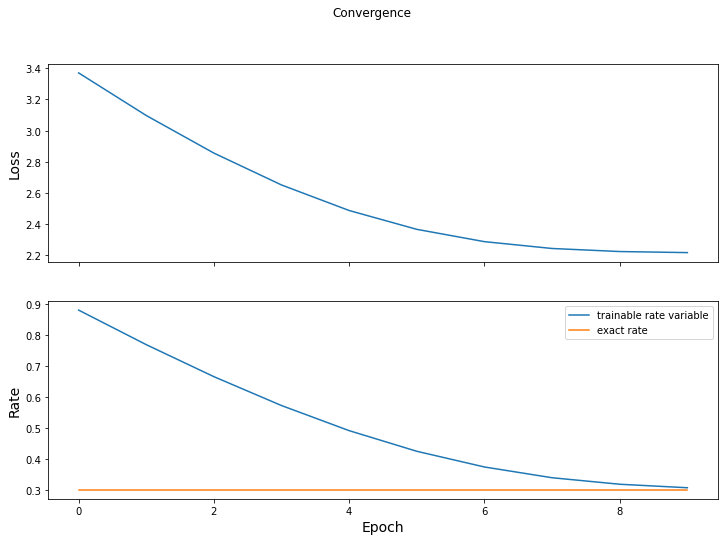

In [120]:
# Plot to see the convergence of the estimated and true parameters

tensor_exact_value = tf.constant(exact_value, shape=[len(train_rate_results)])

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Convergence')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Rate", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_rate_results, label='trainable rate variable')
axes[1].plot(tensor_exact_value, label='exact rate')
axes[1].legend()
plt.show()

In [122]:
# Making a function get_data which:
#   1) Fetches the 20 newsgroup dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):

    newsgroups_train_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                               subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/',
                                              subset='test', categories=categories)

    n_documents = len(newsgroups_train_data['data'])
    count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents) 
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data']) 
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data']) 

    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),  (test_binary_bag_of_words.todense(), newsgroups_test_data['target'])


In [123]:
# Defining a function to conduct laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class.

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameters for Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

    return theta

In [127]:
# Now we will do a function that given the feature occurence counts returns a Bernoulli distribution of 
# batch_shape=number of classes and event_shape=number of features.

def make_distributions(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs) # shape (n_classes, n_words)
    dist = tfd.Independent(batch_of_bernoullis, reinterpreted_batch_ndims=1)
    return dist

In [125]:
# Function which computes the prior probability of every class based on frequency of occurence in 
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts / np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

In [138]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#   1) Computes the class conditional probabilities given the sample
#   2) Forms the joint likelihood
#   3) Normalises the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    #joint_likelihood = tf.add(np.log(priors), cond_probs)
    joint_likelihood = np.log(priors, dtype='float') + cond_probs
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor

    return log_prob

In [134]:
# Now we learn the distribution using gradient tape

def make_distribution_withGT(data, labels, nb_classes):

    class_data = []
    train_vars = []
    distributions = []
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(low=0.01, high =0.1, size=data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask, :])

    for c_num in range(0,nb_classes):
        optimizer = tf.keras.optimizers.Adam()
        print('\n%-------------------%')
        print('Class ', c_num)
        print('%-------------------%')

        for i in range(0,100):
            loss, grads = get_loss_and_grads(class_data[c_num], distributions[c_num])
            if (i%10==0):
                print('iter: {} loss: {}'.format(i, loss))
            optimizer.apply_gradients(zip(grads, distributions[c_num].trainable_variables))
            
            eta = 1e-3
            clipped_probs = tf.clip_by_value(distributions[c_num].trainable_variables,
                                             clip_value_min = eta, clip_value_max = 1)
            train_vars[c_num] = tf.squeeze(clipped_probs)

    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist,reinterpreted_batch_ndims=1)

    print(dist)

    return dist


In [135]:
# Make the same Naive Bayes classifier we did last tutorial

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)

smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

priors = class_priors(n_classes=len(categories), labels=train_labels)
tf_dist = make_distributions(smoothed_counts)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [136]:
# Now train the distributions with gradient tape

GT_dist = make_distribution_withGT(data=train_data, labels=train_labels, nb_classes=4)


%-------------------%
Class  0
%-------------------%
iter: 0 loss: 0.07869270935450655
iter: 10 loss: 0.0693327960204627
iter: 20 loss: 0.06061379005381849
iter: 30 loss: 0.052546459498423605
iter: 40 loss: 0.04507942220840735
iter: 50 loss: 0.03816768051566863
iter: 60 loss: 0.03176820459832696
iter: 70 loss: 0.025850598162136203
iter: 80 loss: 0.020375013233744223
iter: 90 loss: 0.015278614727593665

%-------------------%
Class  1
%-------------------%
iter: 0 loss: 0.07128202131209263
iter: 10 loss: 0.06195601609261698
iter: 20 loss: 0.053176388507318935
iter: 30 loss: 0.045013629869150154
iter: 40 loss: 0.03745370010871654
iter: 50 loss: 0.03046619706993131
iter: 60 loss: 0.024012524902349168
iter: 70 loss: 0.01804315636642935
iter: 80 loss: 0.012525347596868866
iter: 90 loss: 0.007426096389202627

%-------------------%
Class  2
%-------------------%
iter: 0 loss: 0.07863878631632744
iter: 10 loss: 0.06951914178238548
iter: 20 loss: 0.06110210666095694
iter: 30 loss: 0.05342791958

In [139]:
# Compare the two results

for dist in [GT_dist,tf_dist]:
    probabilities = []
    for sample, label in zip(test_data, test_labels):
        probabilities.append(predict_sample(dist, sample, priors))

    probabilities = np.asarray(probabilities)
    predicted_classes = np.argmax(probabilities, axis =-1)
    print('f1 ', f1_score(test_labels, predicted_classes, average='macro'))

f1  0.8288151922966402
f1  0.7848499112849504
